# ENCUESTA DE SALUD Y TRABAJO

El objetivo de este proyecto es describir las disparidades entre generos expresados en la ultima Encuesta Nacional a trabajadores sobre Condiciones de Empleo, Trabajo, Salud y Seguridad (ECETSS 2018).
Iniciamos el trabajo importando los paquetes necesarios.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Importamos el archivo .csv que contiene la información relevada en las encuestas.

In [2]:
dataroot = "https://raw.githubusercontent.com/manlio99/Materia-de-aprendizaje/master/3_MidtermProjects/trabajadores/ecetss_ocupados.csv"
df = pd.read_csv(dataroot)
print(df.head)
print(df.shape)
print(df.columns)

<bound method NDFrame.head of          codmuestra  hogar  region  ...  edad_0a5  edad_6a11  edad_12a17
0     002-0001-0009      1      10  ...         1          1           1
1     002-0001-0012      1      10  ...         1          1           1
2     002-0001-0013      1      10  ...         1          2           1
3     002-0001-0015      1      10  ...         1          1           1
4     002-0001-0017      1      10  ...         1          1           1
...             ...    ...     ...  ...       ...        ...         ...
8961  584-0090-0157      1      44  ...         1          1           1
8962  584-0090-0248      1      44  ...         1          1           2
8963  584-0090-0278      1      44  ...         1          1           1
8964  584-0090-0309      1      44  ...         1          1           1
8965  584-0090-0339      1      44  ...         1          1           1

[8966 rows x 373 columns]>
(8966, 373)
Index(['codmuestra', 'hogar', 'region', 'ponderaocup',

## Hacemos una limpieza inicial básica y evaluamos los resultados de 2 modelos (LDA y decision tree).

Nos quedamos unicamente con los features que evaluan a la totalidad de la poblacion encuestada.

In [3]:
df1 = df.dropna(axis=1)     #Eliminamos aquellos features que contienen valores NaN
print(df1.shape)
print(df1.columns)

df2 = df1.drop(['codmuestra','C3P15.1'], axis=1)    #Eliminamos estas 2 columnas del DF porque no contienen valores numéricos
print(df2.shape)

(8966, 135)
Index(['codmuestra', 'hogar', 'region', 'ponderaocup', 'C0P10.2', 'C0P10.3',
       'C3P16.1', 'C3P16.2', 'nivel_ed', 'C3P16.6',
       ...
       'trabdom_noremu', 'C3P15.1', 'C3P15.2', 'C3P15.3', 'C3P17.1',
       'edadhogar', 'pershog_ag', 'edad_0a5', 'edad_6a11', 'edad_12a17'],
      dtype='object', length=135)
(8966, 133)


Eliminamos las filas/registros que corresponden a respuestas Ns/Nc, que podrían introducir ruido en la clasificación inicial.

In [23]:
nsnc1 = df2[df2.eq(99).any(1)]
nsnc1_r = np.asarray(nsnc1.index)
print(nsnc1_r.shape)

nsnc2 = df2[df2.eq(-99).any(1)]
nsnc2_r = np.asarray(nsnc2.index)
print(nsnc2_r.shape)

nsnc3 = df2[df2.eq(999).any(1)]
nsnc3_r = np.asarray(nsnc3.index)
print(nsnc3_r.shape)

nsnc_all = np.concatenate((nsnc1_r, nsnc2_r, nsnc3_r), axis=0)
nsnc_all = np.array(list(dict.fromkeys(nsnc_all)))    #Generamos un array que contiene las filas que deseamos eliminar del DF por contener valores NS/NC
(print(nsnc_all.shape))

df3 = df2.drop(nsnc_all)
print(df3.shape)

(1777,)
(1217,)
(0,)
(2216,)
(6750, 133)


Elaboración de un clasificador usando el dataframe depurado muy rápido para tener una referencia de las métricas obtenidas de base. Creamos los subconjuntos de entrenamiento y testeo.

In [25]:
from sklearn.model_selection import train_test_split

dat = df3.drop(columns='C3P16.1')
print(dat.shape)
tar = df3['C3P16.1']
print(tar.shape)

train_dat, test_dat, train_tar, test_tar = train_test_split(dat, tar, random_state= 1, test_size= 0.3)

(6750, 132)
(6750,)


Aplicamos un método de clasificación por LDA (Linear Discriminant Analysis) y evaluamos su performance.

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics

lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(train_dat,train_tar)

pred1 = lda.predict(test_dat)
acc1 = metrics.accuracy_score(test_tar,pred1)
prec1 = metrics.precision_score(test_tar,pred1)
f_mes1 =metrics.f1_score(test_tar,pred1)

print('La exactitud del modelo fue:',acc1)
print('La precisión del modelo fue:',prec1)
print('El valor de f-measure fue:',f_mes1)

La exactitud del modelo fue: 0.7782716049382716
La precisión del modelo fue: 0.8075601374570447
El valor de f-measure fue: 0.8072133963074279


Visualizamos los resultados del modelo con LDA graficando la matriz de confusión.

[[940 225]
 [224 636]]


Text(0.5, 257.44, 'Clase Predicha')

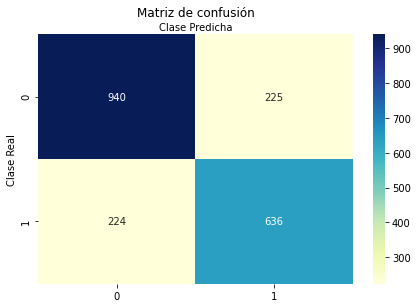

In [27]:
mtx0=metrics.confusion_matrix(test_tar,pred1)
print(mtx0)

clases=[0,1]           
fig,ax = plt.subplots()
referencias = np.arange(len(clases))
plt.xticks(referencias, clases)
plt.yticks(referencias, clases)

sns.heatmap(pd.DataFrame(mtx0), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')

Aplicamos un método de clasificación por árboles de decisión y evaluamos su performance.

|--- feature_12 <= 8401.50
|   |--- feature_13 <= 33214.00
|   |   |--- feature_13 <= 10312.50
|   |   |   |--- feature_43 <= 4.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_43 >  4.50
|   |   |   |   |--- class: 1
|   |   |--- feature_13 >  10312.50
|   |   |   |--- feature_125 <= 2.50
|   |   |   |   |--- class: 2
|   |   |   |--- feature_125 >  2.50
|   |   |   |   |--- class: 1
|   |--- feature_13 >  33214.00
|   |   |--- feature_19 <= 30.50
|   |   |   |--- feature_38 <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_38 >  3.50
|   |   |   |   |--- class: 2
|   |   |--- feature_19 >  30.50
|   |   |   |--- feature_12 <= 5400.00
|   |   |   |   |--- class: 1
|   |   |   |--- feature_12 >  5400.00
|   |   |   |   |--- class: 1
|--- feature_12 >  8401.50
|   |--- feature_39 <= 2.50
|   |   |--- feature_13 <= 57713.50
|   |   |   |--- feature_38 <= 2.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_38 >  2.50
|   |   |   |   |--- class: 2
|   |   |---

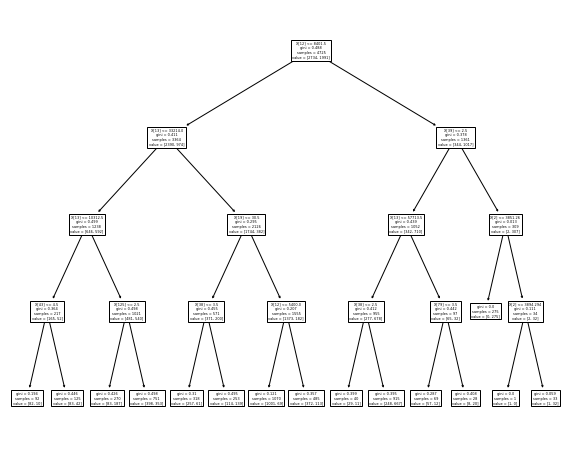

In [28]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(max_depth=4)
dt = dt.fit(train_dat,train_tar)

fig1 = plt.figure(figsize=(10,8))
pred2 = dt.predict(test_dat)
tree.plot_tree(dt)

text_rep = tree.export_text(dt)
print(text_rep)

acc2 = metrics.accuracy_score(test_tar,pred2)
prec2 = metrics.precision_score(test_tar,pred2)
f_mes2 =metrics.f1_score(test_tar,pred2)

print('La exactitud del modelo fue:',acc2)
print('La precisión del modelo fue:',prec2)
print('El valor de f-measure fue:',f_mes2)

Visualizamos los resultados del modelo de arbol de decisión graficando la matriz de confusión.

[[946 219]
 [335 525]]


Text(0.5, 257.44, 'Clase Predicha')

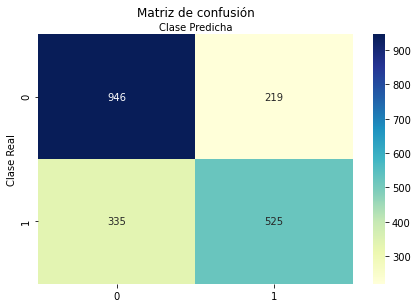

In [29]:
mtx1=metrics.confusion_matrix(test_tar,pred2)
print(mtx1)

clases=[0,1]           
fig,ax = plt.subplots()
referencias = np.arange(len(clases))
plt.xticks(referencias, clases)
plt.yticks(referencias, clases)

sns.heatmap(pd.DataFrame(mtx1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')

## Con estos resultados hacemos la reduccion de dimensionalidad del dataset tomando los features con mayor información (hasta el nivel 4 del árbol) y volvemos a evaluar las métricas de distintos modelos de clasificación.

In [30]:
print(df3.shape)
print(df3.columns[[12,13,43,125,19,38,39,122,2]],'\n')   #Estos corresponden a los features principales según el árbol de decisión

df3b = df3[df3.columns[[12,13,43,125,19,38,39,122,2]]]
print(df3b.shape)
print(df3b.head())

(6750, 133)
Index(['cat_ocup', 'rama_caes', 'radiac', 'C3P15.2', 'redes_sociales',
       'francos_dom', 'lugar_trab', 'capac_laboral', 'ponderaocup'],
      dtype='object') 

(6750, 9)
   cat_ocup  rama_caes  radiac  ...  lugar_trab  capac_laboral  ponderaocup
0         3       8501       5  ...           4              2  7376.238659
2         3       6500       5  ...           4              1  3688.119329
3         3       8600       5  ...           4              1  3688.119329
5         3       9401       5  ...           4              1   181.110014
6         3       7000       5  ...           3              1   181.110014

[5 rows x 9 columns]


Creamos los nuevos subconjuntos de entrenamiento y testeo para evaluar distintos métodos de clasificación y su performance.

In [31]:
train_dat2, test_dat2, train_tar, test_tar = train_test_split(df3b, tar, random_state= 1, test_size= 0.3)
print(train_dat2.shape)
print(test_dat2.shape)

(4725, 9)
(2025, 9)


Aplicamos nuevamente el método de clasificación LDA a nuestro dataframe depurado, evaluamos su performance y visualizamos la matriz de confusión.

La exactitud del modelo fue: 0.7120987654320987
La precisión del modelo fue: 0.7504302925989673
El valor de f-measure fue: 0.7494628276751182
[[872 293]
 [290 570]]


Text(0.5, 257.44, 'Clase Predicha')

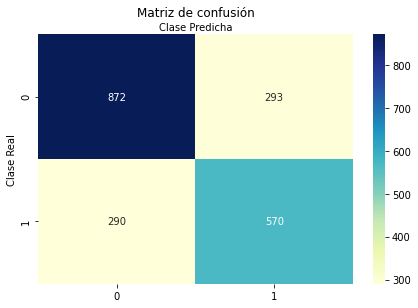

In [32]:
lda2 = LinearDiscriminantAnalysis(solver='svd')
lda2.fit(train_dat2,train_tar)

pred3 = lda2.predict(test_dat2)
acc3 = metrics.accuracy_score(test_tar,pred3)
prec3 = metrics.precision_score(test_tar,pred3)
f_mes3 =metrics.f1_score(test_tar,pred3)

print('La exactitud del modelo fue:',acc3)
print('La precisión del modelo fue:',prec3)
print('El valor de f-measure fue:',f_mes3)

mtx3=metrics.confusion_matrix(test_tar,pred3)
print(mtx3)

clases=[0,1]           
fig,ax = plt.subplots()
referencias = np.arange(len(clases))
plt.xticks(referencias, clases)
plt.yticks(referencias, clases)

sns.heatmap(pd.DataFrame(mtx3), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')

Aplicamos un método de SVM a nuestro dataframe depurado, evaluamos su performance y visualizamos la matriz de confusión.

In [33]:
from sklearn import svm

svm = svm.SVC(kernel='rbf' , gamma='scale')
svm.fit(train_dat2,train_tar)

pred4 = svm.predict(test_dat2)
acc4 = metrics.accuracy_score(test_tar,pred4)
prec4 = metrics.precision_score(test_tar,pred4)
f_mes4 =metrics.f1_score(test_tar,pred4)

print('La exactitud del modelo fue:',acc4)
print('La precisión del modelo fue:',prec4)
print('El valor de f-measure fue:',f_mes4)

La exactitud del modelo fue: 0.665679012345679
La precisión del modelo fue: 0.7147887323943662
El valor de f-measure fue: 0.7057800956106041


[[812 353]
 [324 536]]


Text(0.5, 257.44, 'Clase Predicha')

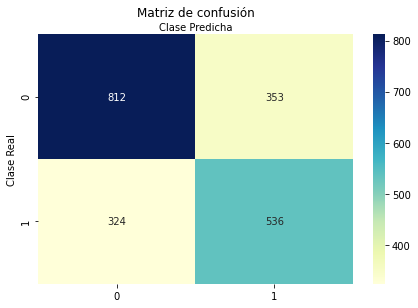

In [34]:
mtx4=metrics.confusion_matrix(test_tar,pred4)
print(mtx4)

clases=[0,1]           
fig,ax = plt.subplots()
referencias = np.arange(len(clases))
plt.xticks(referencias, clases)
plt.yticks(referencias, clases)

sns.heatmap(pd.DataFrame(mtx4), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')

Aplicamos nuevamente el método de clasificación por árboles de decisión, evaluamos su performance y visualizamos la matriz de confusión.

La exactitud del modelo fue: 0.7066666666666667
La precisión del modelo fue: 0.7528786536758193
El valor de f-measure fue: 0.7410636442894507


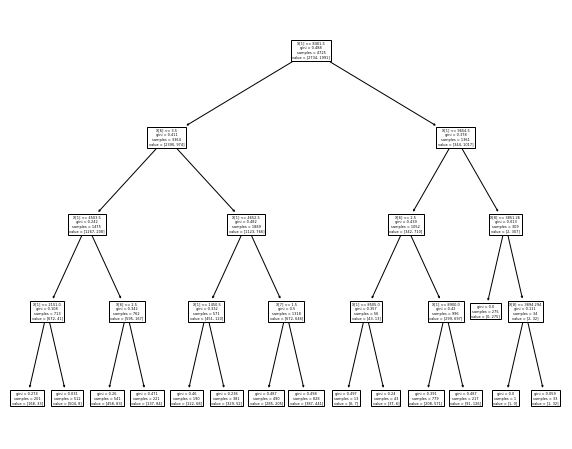

In [35]:
dt2 = tree.DecisionTreeClassifier(max_depth=4)
dt2 = dt2.fit(train_dat2,train_tar)

pred5 = dt2.predict(test_dat2)
fig2 = plt.figure(figsize=(10,8))
tree.plot_tree(dt2)

acc5 = metrics.accuracy_score(test_tar,pred5)
prec5 = metrics.precision_score(test_tar,pred5)
f_mes5 =metrics.f1_score(test_tar,pred5)

print('La exactitud del modelo fue:',acc5)
print('La precisión del modelo fue:',prec5)
print('El valor de f-measure fue:',f_mes5)

[[850 315]
 [279 581]]


Text(0.5, 257.44, 'Clase Predicha')

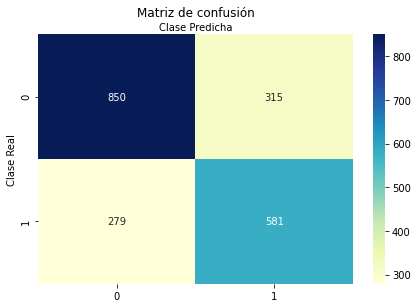

In [36]:
mtx5=metrics.confusion_matrix(test_tar,pred5)
print(mtx5)

clases=[0,1]           
fig,ax = plt.subplots()
referencias = np.arange(len(clases))
plt.xticks(referencias, clases)
plt.yticks(referencias, clases)

sns.heatmap(pd.DataFrame(mtx5), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')

# Conclusión
*   Como se puede observar se obtienen resultados similares usando el 
dataframe luego de una limpieza básica (133 features en total) vs el dataframe depurado (10 features en total).
*   Linear Discriminant Analysis fue el método de clasificación (de los evaluados) que mejor se adecuo al dataframe trabajado.